In [1]:
from IPython.display import display, HTML 
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
 """))

In [103]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist                     # MNIST 데이터셋
from tensorflow.keras.utils import to_categorical               # 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt                            # 학습과정 loss와 acc 시각화
# quiz에서는 scale조정, train_test_split 등을 추가 , 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model
from sklearn.metrics import confusion_matrix

- Red Wine 등급 예측

1. 데이터 셋 확보 및 전처리 
    csv -> 결측치 처리 -> 독립변수와 타겟변수 분리 -> 독립변수 스케일 조정
    -> 타겟변수의 원핫인코딩 -> 훈련셋과 데이트셋분리(train_test_split 층화추출)
    
2. 모델 구성(입력 11, 출력6-pd.getdummies, 출력 9개-to_categorical) layer층 4개 
3. 모델 학습과정 설정 
    loss='categorical_crossentropy
4. 모델 학습 (callbacks이용)
5. 모델 평가 (그래프, 평가, 교차표)
6. 모델 저장 & 사용

# 1.데이터 확보 & 전처리

In [61]:
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)

redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [7]:
redwine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [11]:
# 결측치 없음
redwine.isna().sum().sum() 

0

데이터 셋 확보 및 전처리 csv -> 결측치 처리 -> 독립변수와 타겟변수 분리 -> 독립변수 스케일 조정 -> 타겟변수의 원핫인코딩 -> 훈련셋과 데이트셋분리(train_test_split 층화추출)

In [12]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [62]:
# 입력변수와 타겟변수 분리 
X_data = redwine.iloc[:,:-1] # 독립변수
y_data = redwine.iloc[:,-1] # 타겟변수 

In [63]:
# 입력변수 스케일 조정
scaler_X = MinMaxScaler()
scaled_X_data = scaler_X.fit_transform(X_data)
scaled_X_data

array([[0.24778761, 0.39726027, 0.        , ..., 0.60629921, 0.13772455,
        0.15384615],
       [0.28318584, 0.52054795, 0.        , ..., 0.36220472, 0.20958084,
        0.21538462],
       [0.28318584, 0.43835616, 0.04      , ..., 0.40944882, 0.19161677,
        0.21538462],
       ...,
       [0.15044248, 0.26712329, 0.13      , ..., 0.53543307, 0.25149701,
        0.4       ],
       [0.11504425, 0.35958904, 0.12      , ..., 0.65354331, 0.22754491,
        0.27692308],
       [0.12389381, 0.13013699, 0.47      , ..., 0.51181102, 0.19760479,
        0.4       ]])

In [64]:
# 타겟변수 원핫인코딩
one_hot_encodied_y_data = to_categorical(y_data)
print('원핫인코딩된 데이터 :',one_hot_encodied_y_data)

원핫인코딩된 데이터 : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [65]:
X_data.shape, y_data.shape,scaled_X_data.shape, one_hot_encodied_y_data.shape
# X_train : 독립변수 데이터 
# y_train : 타겟변수 데이터 
# scaled_X_data : 스케일 조정된 독립변수
# one_hot_encodied_y_data : 원핫인코딩된 타겟변수


((1599, 11), (1599,), (1599, 11), (1599, 9))

In [68]:
# 훈련셋과 데이트셋분리(train_test_split 층화추출)
X_train,X_test,Y_train, Y_test = train_test_split(scaled_X_data,one_hot_encodied_y_data,
                                                 test_size=0.3,
                                                 stratify=one_hot_encodied_y_data)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1119, 11), (480, 11), (1119, 9), (480, 9))

모델 구성(입력 11, 출력6-pd.getdummies, 출력 9개-to_categorical) layer층 4개

In [69]:
Y_train[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [83]:
# 모델 구성
model = Sequential()
model.add(Input(shape=11,))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=68, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=42, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=9, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                384       
                                                                 
 dense_7 (Dense)             (None, 68)                2244      
                                                                 
 dropout (Dropout)           (None, 68)                0         
                                                                 
 dense_8 (Dense)             (None, 42)                2898      
                                                                 
 dropout_1 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 9)                 387       
                                                                 
Total params: 5,913
Trainable params: 5,913
Non-traina

In [84]:
model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

In [86]:
# 모델 학습 

earlystopping = EarlyStopping(monitor='val_accuracy',patience=20)
import os
model_save_folder = './model08/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
file = model_save_folder + 'mnist{epoch:03d}_val{val_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath=file,
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max',
                            verbose=1)

hist =model.fit(X_train,Y_train,
                epochs=50,
                batch_size= 100,
                validation_split= 0.2,
                verbose=1,
                callbacks=[earlystopping,checkpoint])

Epoch 1/50
1/9 [==>...........................] - ETA: 3s - loss: 2.1826 - accuracy: 0.1700
Epoch 1: val_accuracy improved from -inf to 0.40179, saving model to ./model08\mnist001_val0.40179.h5
9/9 [==============================] - 1s 25ms/step - loss: 2.1270 - accuracy: 0.3162 - val_loss: 2.0403 - val_accuracy: 0.4018
Epoch 2/50
1/9 [==>...........................] - ETA: 0s - loss: 2.0445 - accuracy: 0.3900
Epoch 2: val_accuracy did not improve from 0.40179
9/9 [==============================] - 0s 7ms/step - loss: 1.9682 - accuracy: 0.4112 - val_loss: 1.8271 - val_accuracy: 0.3795
Epoch 3/50
1/9 [==>...........................] - ETA: 0s - loss: 1.7982 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.40179
9/9 [==============================] - 0s 6ms/step - loss: 1.7410 - accuracy: 0.4268 - val_loss: 1.5397 - val_accuracy: 0.3795
Epoch 4/50
1/9 [==>...........................] - ETA: 0s - loss: 1.5837 - accuracy: 0.4400
Epoch 4: val_accuracy did not improve from 0.4

Epoch 29/50
1/9 [==>...........................] - ETA: 0s - loss: 1.0270 - accuracy: 0.5900
Epoch 29: val_accuracy did not improve from 0.70536
9/9 [==============================] - 0s 7ms/step - loss: 1.0295 - accuracy: 0.5620 - val_loss: 0.8636 - val_accuracy: 0.7009
Epoch 30/50
1/9 [==>...........................] - ETA: 0s - loss: 1.1707 - accuracy: 0.5400
Epoch 30: val_accuracy improved from 0.70536 to 0.71429, saving model to ./model08\mnist030_val0.71429.h5
9/9 [==============================] - 0s 8ms/step - loss: 1.0213 - accuracy: 0.5587 - val_loss: 0.8579 - val_accuracy: 0.7143
Epoch 31/50
1/9 [==>...........................] - ETA: 0s - loss: 1.0671 - accuracy: 0.5100
Epoch 31: val_accuracy did not improve from 0.71429
9/9 [==============================] - 0s 6ms/step - loss: 1.0144 - accuracy: 0.5654 - val_loss: 0.8564 - val_accuracy: 0.6964
Epoch 32/50
1/9 [==>...........................] - ETA: 0s - loss: 1.0732 - accuracy: 0.5700
Epoch 32: val_accuracy did not improv

In [87]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

모델 평가 (그래프, 평가, 교차표)

모델 저장 & 사용

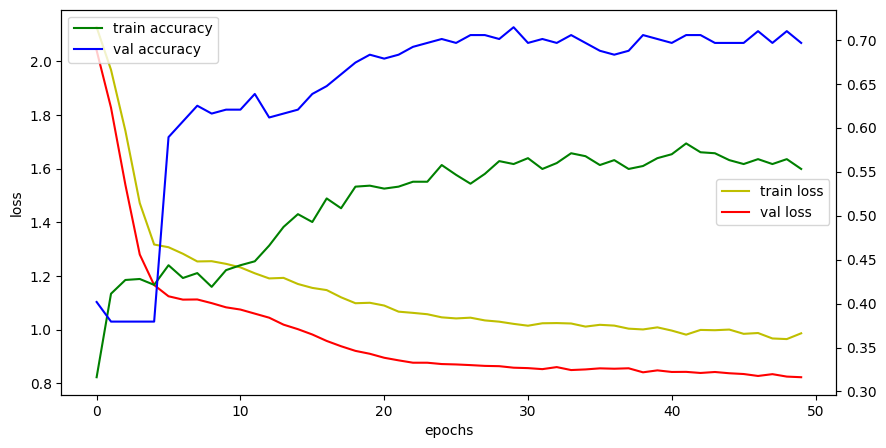

In [88]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'],'r', label='val loss')
acc_ax= loss_ax.twinx() #x축 공유
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [96]:
# 어떤 모델 쓸지 
loss_and_acc = model.evaluate(X_test,Y_test, batch_size=32, verbose=0)
print('현 모델의 loss :', loss_and_acc[0])
print('현 모델의 accuracy :', loss_and_acc[1])
model2 = load_model('model08/mnist030_val0.71429.h5')
loss_and_acc_2 = model2.evaluate(X_test,Y_test, batch_size=32, verbose=0)
print('저장된 모델 중 best모델 loss :', loss_and_acc_2[0])
print('저장된 모델 중 best모델 accuracy :', loss_and_acc_2[1])

현 모델의 loss : 0.940241277217865
현 모델의 accuracy : 0.59375
저장된 모델 중 best모델 loss : 0.9731571078300476
저장된 모델 중 best모델 accuracy : 0.5979166626930237


In [89]:
# 모델 평가하기 
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=100, verbose=2)
print('loss :', loss_and_metrics[0])
print('accuracy :', loss_and_metrics[1])

5/5 - 0s - loss: 0.9402 - accuracy: 0.5938 - 25ms/epoch - 5ms/step
loss : 0.9402412176132202
accuracy : 0.59375


In [98]:
# 실제값
y = Y_test.argmax(axis=1)

In [99]:
# 예측값
yhat = model.predict(X_test).argmax(axis=1)
yhat

15/15 [==============================] - 0s 1ms/step


array([6, 6, 5, 5, 5, 6, 7, 7, 5, 6, 5, 6, 5, 6, 5, 6, 5, 5, 6, 5, 6, 6,
       6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 5, 6, 5, 6, 5, 5, 5, 5, 5,
       5, 6, 5, 5, 6, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 5, 5, 5, 6,
       5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5,
       6, 5, 5, 6, 6, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5,
       6, 6, 5, 6, 6, 5, 6, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 6, 6, 5, 6, 5,
       5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 5, 6, 5,
       6, 5, 6, 6, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 6, 5, 6, 5, 5, 7, 5, 6,
       6, 6, 6, 5, 7, 5, 5, 5, 5, 6, 5, 5, 5, 5, 7, 6, 6, 5, 5, 5, 6, 6,
       6, 5, 6, 5, 5, 5, 6, 5, 6, 7, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5,
       5, 7, 6, 5, 5, 6, 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5,
       6, 6, 6, 6, 7, 6, 5, 5, 5, 5, 7, 5, 6, 6, 6, 6, 5, 6, 5, 5, 5, 6,
       6, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 6, 7, 6, 5, 6, 5, 5, 6,
       5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 5,

In [106]:
pd.crosstab(y,yhat, rownames=['실제값'],colnames=['예측값'])

예측값,5,6,7
실제값,,,
3,2,1,0
4,13,3,0
5,158,45,1
6,69,112,11
7,2,43,15
8,0,3,2


In [104]:
confusion_matrix(y,yhat)

array([[  0,   0,   2,   1,   0,   0],
       [  0,   0,  13,   3,   0,   0],
       [  0,   0, 158,  45,   1,   0],
       [  0,   0,  69, 112,  11,   0],
       [  0,   0,   2,  43,  15,   0],
       [  0,   0,   0,   3,   2,   0]], dtype=int64)

In [109]:
# 틀린 갯수 
# 전체 - 전체*정확도 = 틀린갯수
1599-1599*loss_and_acc_2[0]

42.921784579753876

In [108]:
cnt = 0
for y,h in zip(y, yhat):
    if y!=h:
        cnt += 1
print('틀린갯수 :', cnt)

틀린갯수 : 195


In [102]:
model.save('model/09wine.h5')